In [25]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import os.path

try:
    import pyradi.ryplot as ryplot 
    pyradiryplotImported = True
except ImportError:
    pyradiryplotImported = False



# get rbf from here: https://github.com/treverhines/RBF.git
import rbf

## Using radial basis functions for smoothing/interpolation on a sphere

**This work was made possible by Trever Hines**, the man behind https://github.com/treverhines/RBF.git. 
Trever Hines kindly reworked  and updated his RBF module to perform interpolation on a sphere.  The data is converted from azimuth and polar/elevation angles to (x,y,z), which are then interpolated over in the Cartesian domain. His approach obtain the symmetry around the sphere and does not require any special spherical kernels. Trever's example script is shown below. 

See here for a general introduction on interpolation by radial basis functions:  
https://github.com/NelisW/PythonNotesToSelf/blob/master/RBF-Interpolation.ipynb

Scipy has some RBF interpolation functionality but not quite what we need here:  
http://scipy-cookbook.readthedocs.io/items/RadialBasisFunctions.html

There is a more powerful radial base function package available here:  
https://github.com/treverhines/RBF   
https://rbf.readthedocs.io/en/latest/  
which provides additional capabilities not available in the scipy package.

Note It appears that Hines follow the Scipy convention for $\epsilon = \sigma$ in a Gauss function.

Radial basis functions can be used for smoothing/interpolating scattered/unstructured data in n-dimensions, but should be used with caution for extrapolation outside of the observed data range.


In [2]:
# seed for random number generator
rseed = 1
# number of observation points 
nobs = 100

## General support functions


In [3]:
def spherical_to_cartesian(azim,elev):
    """Convert azimuth/elevation angles to (x,y,z) on a sphere, Numpy version.
    
    Azimuth in the domain $[0..2\pi]$
    Elevation in the domain $[-\pi/2..\pi/2]$
    
    Returns [x,y,z] values on a sphere
    """
    x = np.sin(elev+np.pi/2)*np.cos(azim)  
    y = np.sin(elev+np.pi/2)*np.sin(azim)  
    z = np.cos(elev+np.pi/2)
    return np.array([x,y,z]).T

In [4]:
def spherical_to_cartesianDf(row):
    """Convert azimuth/elevation angles to (x,y,z) on a sphere, Pandas version.
    
    Azimuth in the domain $[0..2\pi]$
    Elevation in the domain $[-\pi/2..\pi/2]$
    
    Returns new columns for [x,y,z] values on a sphere
    """
    x = np.sin(row['Elev']+np.pi/2) * np.cos(row['Azim'])  
    y = np.sin(row['Elev']+np.pi/2) * np.sin(row['Azim'])  
    z = np.cos(row['Elev'])
    return pd.Series({'x':x, 'y':y, 'z':z})    



In [5]:
def makeRegGrid(gint_azim, gint_elev):
    """Make a regular grid of points in mesh form, given azimuth and elevation coordinates
    
    Azimuth in the domain $[0..2\pi]$
    Elevation in the domain $[-\pi/2..\pi/2]$
    
    Inputs:
        gint_azim azimuth grid interval in degrees
        gint_elev elevation grid interval in degrees
    
    Returns
        msh_azim 2D mesh grid varying along azimuth
        msh_elev 2D mesh grid varying along elevation
   
    """

    num_azim = int(360 / gint_azim + 1)
    num_elev = int(180 / gint_elev + 1)
    grd_azimV = np.linspace(0.0,2*np.pi,num_azim)
    grd_elevV = np.linspace(-np.pi/2,np.pi/2,num_elev)
    msh_azim,msh_elev = np.meshgrid(grd_azimV,grd_elevV)

    return msh_azim,msh_elev,grd_azimV,grd_elevV

In [6]:
def true_function(msh_azim,msh_elev,ftype='original'):
    """Create different test targets
    """
    
    if 'asym-cardoid' in ftype:
        razim = 1 + np.sin(msh_azim)
        relev = np.cos(msh_elev) * np.abs(np.tan(1.3* np.pi/2+0.2*msh_elev))
        out = 0.1 + razim * relev 
    elif 'basic' in ftype:
        out = np.cos(msh_azim) * np.cos(msh_elev)
    else:   
        # create some arbitary function that we want to recontruct with interpolation
        cart = spherical_to_cartesian(msh_azim,msh_elev)
        out = (np.cos(cart[:,2] - 1.0) *
             np.cos(cart[:,0] - 1.0) *
             np.cos(cart[:,1] - 1.0))
    return out

In [7]:
def makeTestSet(nobs,ftype,rseed=1):
    np.random.seed(rseed)
    # make the observation points in spherical coordinates 
    obs_azim = np.random.uniform(0.0,2*np.pi,nobs)
    obs_elev = np.random.uniform(-np.pi/2,np.pi/2,nobs)
    # get the catesian coordinates for the observation points
    obs_cart = spherical_to_cartesian(obs_azim,obs_elev)
    # get the latent function at the observation points
    obs_vals = true_function(obs_azim,obs_elev,ftype=ftype)
    return obs_cart, obs_vals, obs_azim, obs_elev


In [30]:
def writeFunction(filename, nobs,ftype='original',rseed=rseed,
                  rscale=[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]):
    """Create different test targets, write to file
    
    The filename as given is preprended by the data function type.
    
    Inputs:
        filename: filename to be used when writing
        nobs: number of data samples in the file, randomly created 
              azim in [0..2\pi], elel in [\pi/20..\pi/2]
        ftype: data function type, one of 'asym-cardoid','basic' or  'original'
        rseed: seed to be used in random number generator
        rscale: set of scale values to be applied in subsequent columnns. The 
                resulting data vector will be multiplied by this scale factor
    
    Returns
        Nothing.
    
    """
    
    obs_cart, obs_vals, obs_azim, obs_elev = makeTestSet(nobs,ftype,rseed)
    out = true_function(obs_azim,obs_elev,ftype=ftype)
    df = pd.DataFrame({'Alti':np.ones(obs_azim.shape),
                       'Azim':obs_azim*180/np.pi,
                       'Elev':obs_elev*180/np.pi,
                       1:out})
    # build the dummy data frame by just scaling out
    for item in rscale[1:]:
        df[item] = df[1] * item
        
    df.to_csv(ftype+filename, index=False,header=False,sep=' ')
    print(f'Data written to {ftype+filename}')
    print(df.head())


writeFunction('testdata.env',nobs=nobs,ftype='asym-cardoid')
writeFunction('testdata.env',nobs=nobs,ftype='basic')
writeFunction('testdata.env',nobs=nobs,ftype='original')


Data written to asym-cardoidtestdata.env
   Alti        Azim       Elev         1       1.1       1.2       1.3  \
0   1.0  150.127922 -31.203918  3.480394  3.828433  4.176472  4.524512   
1   1.0  259.316818   4.870458  0.132516  0.145768  0.159019  0.172271   
2   1.0    0.041175  69.469578  0.505242  0.555767  0.606291  0.656815   
3   1.0  108.839726 -25.691443  4.471665  4.918831  5.365998  5.813164   
4   1.0   52.832121  73.536327  0.671419  0.738561  0.805703  0.872845   

        1.4       1.5       1.6       1.7       1.8       1.9       2.0  
0  4.872551  5.220590  5.568630  5.916669  6.264708  6.612748  6.960787  
1  0.185522  0.198774  0.212025  0.225277  0.238529  0.251780  0.265032  
2  0.707339  0.757864  0.808388  0.858912  0.909436  0.959961  1.010485  
3  6.260331  6.707497  7.154664  7.601830  8.048997  8.496163  8.943330  
4  0.939987  1.007129  1.074271  1.141412  1.208554  1.275696  1.342838  
Data written to basictestdata.env
   Alti        Azim       Elev      

## Demo example from Hines' code

RBF Interpolation on a unit sphere. This is done by converting theta (azimuthal angle) and phi (polar/elevation angle) into cartesian coordinates and then interpolating over R^3.

Credit: script by Trever Hines (treverhines@gmail.com), using his RBF module.  
https://github.com/treverhines/RBF   
https://rbf.readthedocs.io/en/latest/  

The code shown here was converted from Trever's original for polar angle $[0..\pi]$ to elevation angle $[-\pi/2..\pi/2]$.


In [9]:
def plotResultDemo(msh_azim,msh_elev,val_true,val_itp,obs_azim,obs_elev,obs_vals,ierror,ftype):
    ## PLOTTING
    plt.figure(figsize=(20,6))

    # plot in regular grid 
    plt.subplot(1, 3, 1)
    plt.title(f'{ftype} fn: True function')
    p = plt.tripcolor(msh_azim,msh_elev,val_true,cmap='viridis')
    plt.colorbar(p)
    plt.xlabel('Azimuth')
    plt.ylabel('Elevation')
    plt.xlim(0,2*np.pi)
    plt.ylim(-np.pi/2,np.pi/2)
    plt.grid(ls=':',color='k')
    plt.tight_layout()

    # plot the interpolant in spherical coordinates
    plt.subplot(1, 3, 2)
    plt.title(f'{ftype} fn: RBF interpolant (points are observations)')
    # plot the interpolated function
    p = plt.tripcolor(msh_azim,msh_elev,val_itp,cmap='viridis')
    # plot the observations
    plt.scatter(obs_azim,obs_elev,c=obs_vals,
                s=50,edgecolor='k',cmap='viridis',
                vmin=p.get_clim()[0],vmax=p.get_clim()[1])                  
    plt.colorbar(p)
    plt.xlabel('Azimuth')
    plt.ylabel('Elevation')
    plt.xlim(0,2*np.pi)
    plt.ylim(-np.pi/2,np.pi/2)
    plt.grid()
    plt.grid(ls=':',color='k')
    plt.tight_layout()


    if ierror is not None:
        # plot the interpolant in spherical coordinates
        plt.subplot(1, 3, 3)
        plt.title(f'{ftype} fn: Error (points are observations)')
        # plot the interpolated function
        p = plt.tripcolor(msh_azim,msh_elev,ierror,cmap='viridis')
        plt.colorbar(p)
        plt.xlabel('Azimuth')
        plt.ylabel('Elevation')
        plt.xlim(0,2*np.pi)
        plt.ylim(-np.pi/2,np.pi/2)
        plt.grid()
        plt.grid(ls=':',color='k')
        plt.tight_layout()


mean interpolation error: 0.00987128949273392


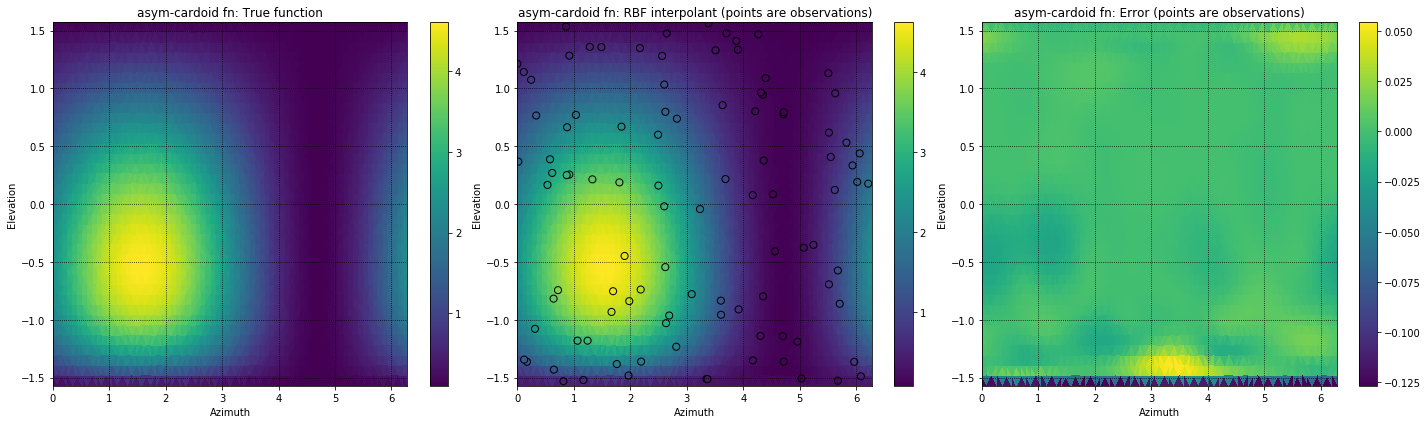

In [10]:
doExample = True

if doExample:
    np.random.seed(rseed)

    # test function name
    ftype = 'asym-cardoid'
#     ftype = 'original'
   
    # create the test input set
    obs_cart, obs_vals, obs_azim, obs_elev = makeTestSet(nobs,ftype)

    #create the interpolation set
    msh_azim,msh_elev,_,_ = makeRegGrid(gint_azim=5, gint_elev=5)
    msh_azim = msh_azim.flatten()
    msh_elev = msh_elev.flatten()

    #the true function in spherical coordinates
    val_true = true_function(msh_azim,msh_elev,ftype=ftype)

    # get the Cartesian coordinates for the interpolation points
    cart_itp = spherical_to_cartesian(msh_azim,msh_elev)

    # eps value
    epsvalue = 1 
    # basis function 
    basisfunction = rbf.basis.phs3
    # create an RBF interpolant from the cartesian observation points.
    # use the default `RBFInterpolant` parameters here, nothing special.
    I = rbf.interpolate.RBFInterpolant(obs_cart,obs_vals,basis=basisfunction,eps=epsvalue)
    # evaluate the interpolant on the interpolation points
    val_itp = I(cart_itp)

    # compute and print the mean L2 error
    ierror = val_true - val_itp
    mean_error = np.mean(np.abs(ierror))
    print('mean interpolation error: %s' % mean_error)

    plotResultDemo(msh_azim,msh_elev,val_true,val_itp,obs_azim,obs_elev,obs_vals,ierror,ftype)

## Read data from file

This example uses similar code from the above example, but reads the data from a file.

The file contains different sample points, each on a new line.
Each line has the following columns:  
`'Alti', 'Azim', 'Elev','R100','R90','R80','R70','R60','R50','R40','R30','R20','R10','R00'`  
where

1. Alti is the altitude for the data point. The data may contain different spherical sub-datasets, but all such points must be on one altitude.

1. Azim is the azimuth angle for the data point $[0..2\pi]$ in degrees, or alternatively only in a hemisphere $[0..\pi]$ in degrees

1. Elev is the elevation angle for the data point $[-\pi/2..\pi/2]$ in degrees.

1. Then follows eleven columns of values to be interpolated.

The output of the interpolation function below is a separate CSV file for each altitude and lookup column on a regular grid that can be interpolated with most available 2-D interpolation software.


For the purpose of testing one of three files are created by the above function `writeFunction(filename,nobs,ftype,rseed,rscale)`, but in the eventual application the files will be created by some other means.

The data file can contain data for only a hemisphere, in which case the full hemisphere is completed by mirroring.

The different RBF functions available are shown in Trever's docs at https://rbf.readthedocs.io/en/latest/basis.html.

Play around with the `epsvalue` for the RBF, values around unity should work fine.


In [11]:
def plotResults2(obs_azim,obs_elev,obs_vals,msh_azim,msh_elev,val_itp):

        plt.figure(figsize=(25,10))

        # plot the input in spherical coordinates
        plt.subplot(1, 2, 1)
        plt.title('Input values')
        # plot the input data
        p = plt.tripcolor(obs_azim,obs_elev,obs_vals,cmap='viridis')
        # plot the observations
        plt.scatter(obs_azim,obs_elev,c=obs_vals,
                    s=50,edgecolor='k',cmap='viridis',
                    vmin=p.get_clim()[0],vmax=p.get_clim()[1])                  
        plt.colorbar(p)
        plt.xlabel('Azimuth')
        plt.ylabel('Elevation')
        plt.xlim(0,2*np.pi)
        plt.ylim(-np.pi/2,np.pi/2)
        plt.grid()
        plt.grid(ls=':',color='k')
        plt.tight_layout()

        # plot the interpolant in spherical coordinates
        plt.subplot(1, 2, 2)
        plt.title('RBF interpolant (points are observations)')
        # plot the interpolated function
        p = plt.tripcolor(msh_azim,msh_elev,val_itp,cmap='viridis')
        # plot the observations
        plt.scatter(obs_azim,obs_elev,c=obs_vals,
                    s=50,edgecolor='k',cmap='viridis',
                    vmin=p.get_clim()[0],vmax=p.get_clim()[1])                  
        plt.colorbar(p)
        plt.xlabel('Azimuth')
        plt.ylabel('Elevation')
        plt.xlim(0,2*np.pi)
        plt.ylim(-np.pi/2,np.pi/2)
        plt.grid()
        plt.grid(ls=':',color='k')
        plt.tight_layout()



asym-cardoidtestdata-1.0-R100.lut:  processing R100, (100, 3) entries


C:\Users\NWillers\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning:

The following kwargs were not used by contour: 'clip_on'



asym-cardoidtestdata-1.0-R90.lut:  processing R90, (100, 3) entries
asym-cardoidtestdata-1.0-R80.lut:  processing R80, (100, 3) entries
asym-cardoidtestdata-1.0-R70.lut:  processing R70, (100, 3) entries
asym-cardoidtestdata-1.0-R60.lut:  processing R60, (100, 3) entries
asym-cardoidtestdata-1.0-R50.lut:  processing R50, (100, 3) entries
asym-cardoidtestdata-1.0-R40.lut:  processing R40, (100, 3) entries
asym-cardoidtestdata-1.0-R30.lut:  processing R30, (100, 3) entries
asym-cardoidtestdata-1.0-R20.lut:  processing R20, (100, 3) entries
asym-cardoidtestdata-1.0-R10.lut:  processing R10, (100, 3) entries
asym-cardoidtestdata-1.0-R00.lut:  processing R00, (100, 3) entries


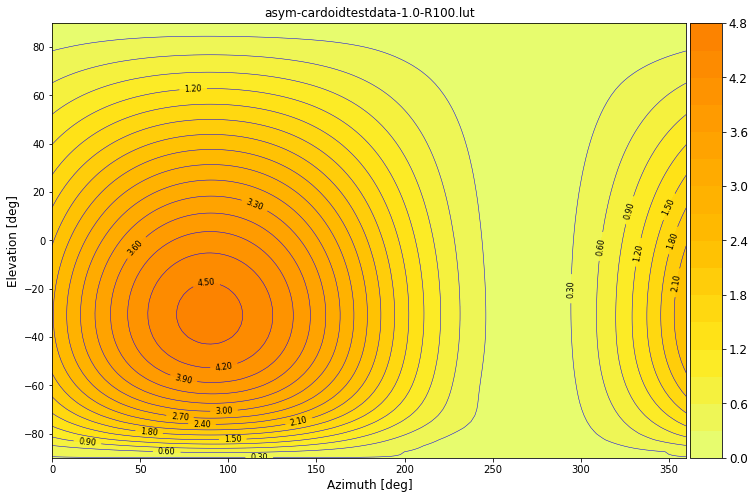

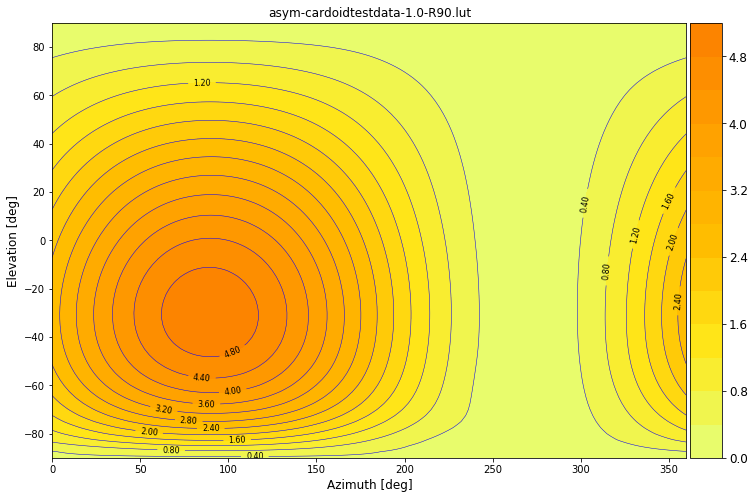

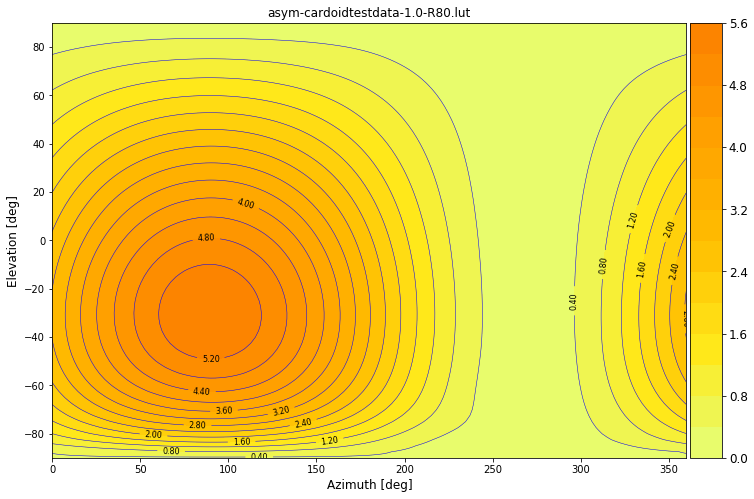

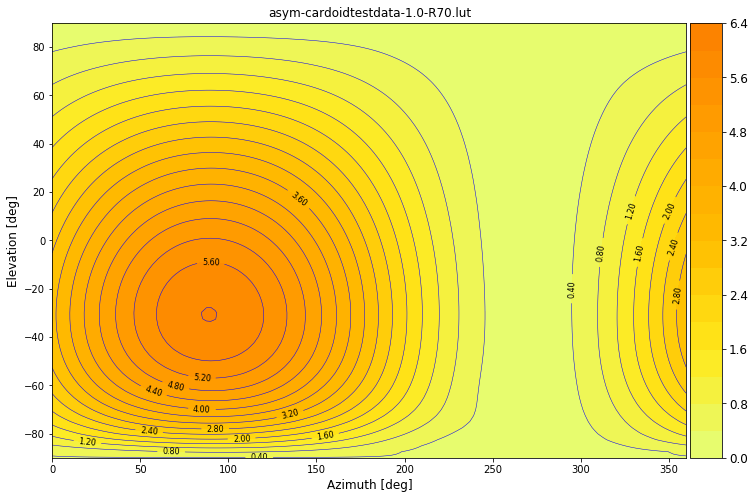

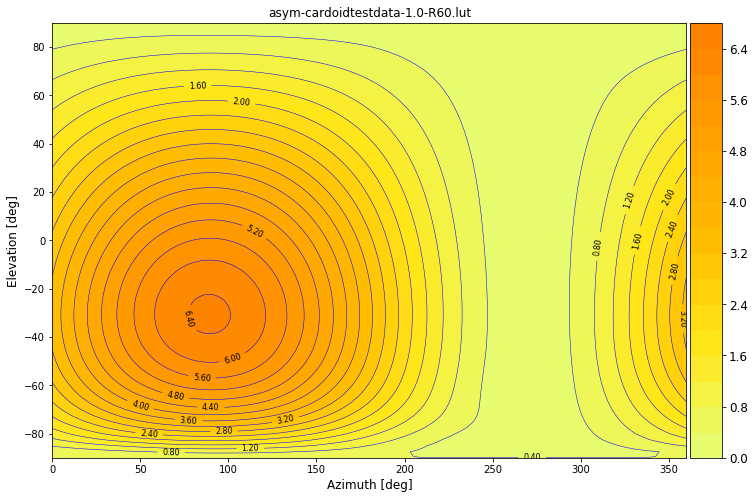

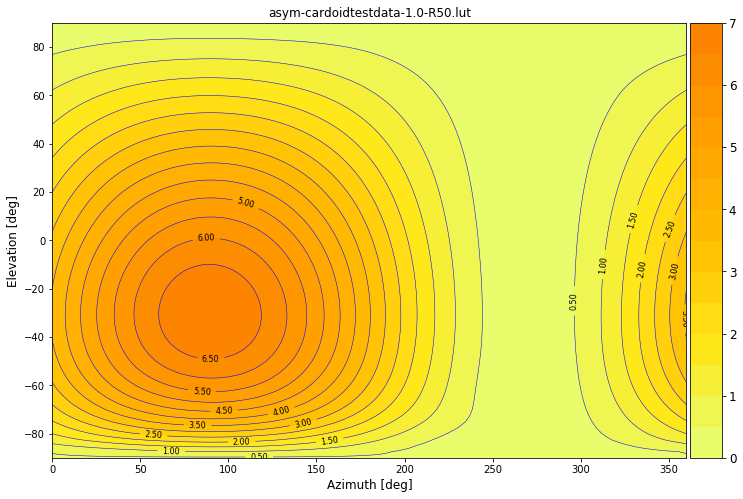

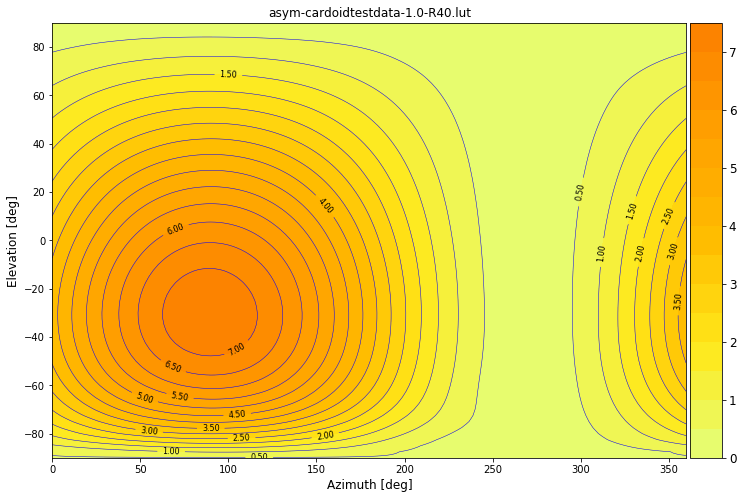

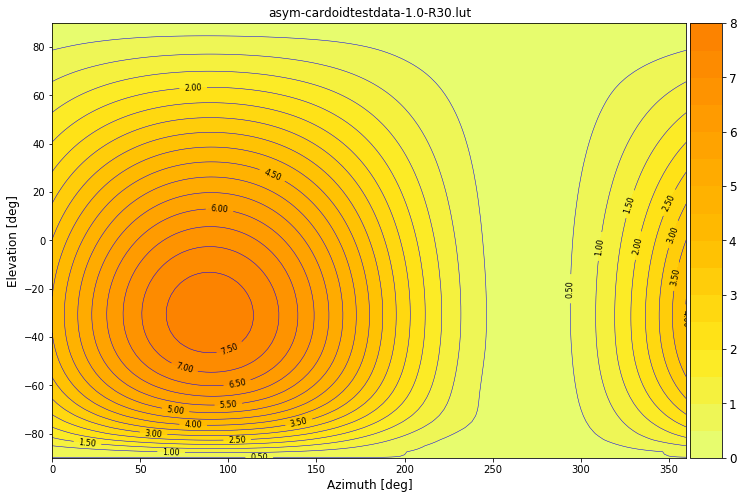

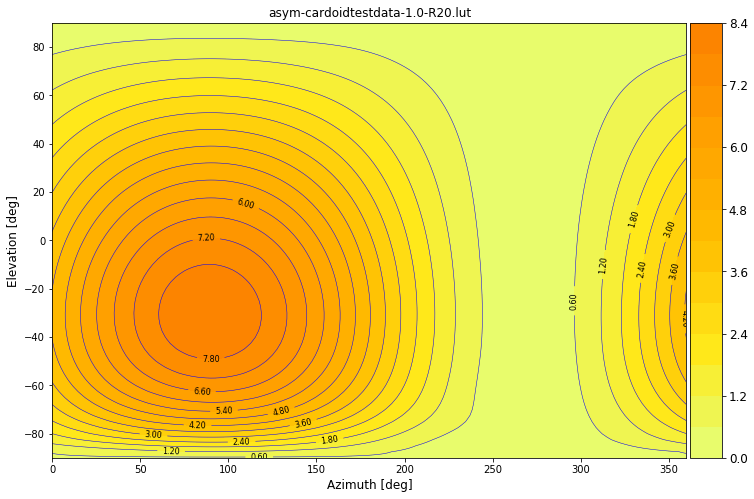

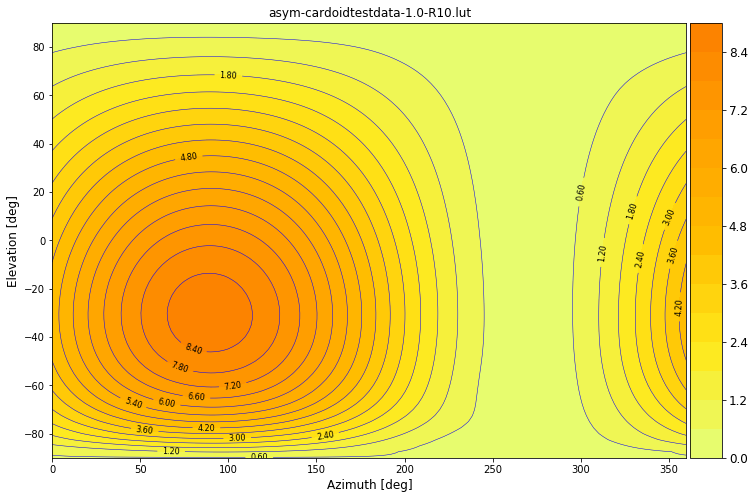

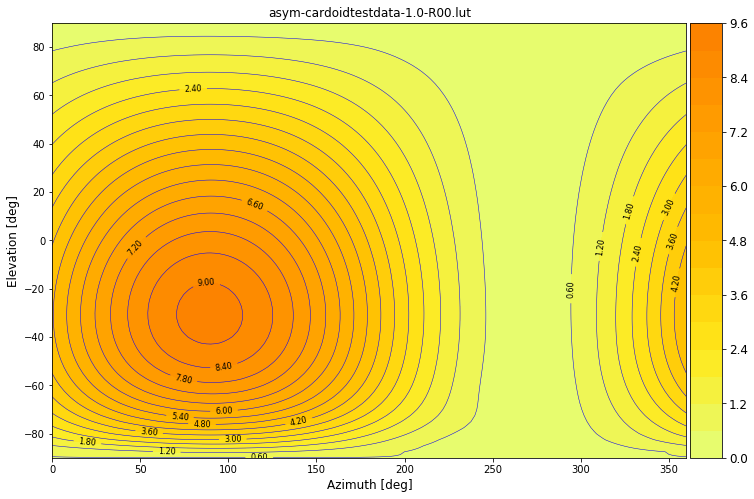

In [39]:
# select one of these data files
filename = 'originaltestdata.env'
filename = 'basictestdata.env'
filename = 'asym-cardoidtestdata.env'

#intervals in the output grid in degrees
gint_azim=2.5
gint_elev=2.5
epsvalue = 1
doPlot = False
datafileregulargrid = False
usespherical_to_cartesian = True

rcolumns = [ 'R100','R90','R80','R70','R60','R50','R40','R30','R20','R10','R00']
columns = ['Alti', 'Azim', 'Elev',] + rcolumns

df = pd.read_csv(filename, names=columns,sep=' ')

# only half hemisphere, fill in the rest
if df[df['Azim']>180].shape[0] == 0:
    dfm = df.copy()
    #remove the two end azim columns, assuming that they already exist
    dfm = dfm[dfm.Azim != 0.]
    dfm = dfm[dfm.Azim != 180.]
    # only positive azim angles
    dfm['Azim'] = 360. - dfm['Azim']
    df = df.append(dfm)
    del dfm
    
if datafileregulargrid:
    randerror = 0.1
    # add random to azim/elev to break regular structure, to avoid singular matrix error
    np.random.seed(rseed)
    df['Azim'] += np.random.uniform(-randerror,randerror,df['Azim'].shape[0])
    df['Elev'] += np.random.uniform(-randerror,randerror,df['Elev'].shape[0])

# get unique values
altiUnique = df['Alti'].unique()
azimUnique = df['Azim'].unique()
elevUnique = df['Elev'].unique()

#create the output interpolation support set
msh_azim,msh_elev,grd_azimV,grd_elevV = makeRegGrid(gint_azim=gint_azim, gint_elev=gint_elev)
# print(msh_azim.shape)
msh_azim = msh_azim.flatten()
msh_elev = msh_elev.flatten()
# get the Cartesian coordinates for the interpolation points
cart_itp = spherical_to_cartesian(msh_azim,msh_elev)

# do for altitudes one at a time
icnt = 0
filenames = []
for alti in altiUnique:
    # and Rx one at a time
    for rcol in rcolumns:
        icnt += 1
        # extract only the columns needed
        dfs = df[df['Alti']==alti][['Azim', 'Elev',rcol]]
        obs_azim = dfs['Azim'].values * np.pi / 180
        obs_elev = dfs['Elev'].values * np.pi / 180
        obs_vals = dfs[rcol].values

        fbasename = ''.join(os.path.basename(filename).split('.')[:-1])
        ofilename = f'{fbasename}-{alti}-{rcol}.lut'
        print(f'{ofilename}:  processing {rcol}, {dfs.shape} entries')
        filenames.append(ofilename)
        
        if usespherical_to_cartesian:
            # use data in raw format to calc cartesian values
            obs_cart = spherical_to_cartesian(obs_azim,obs_elev) 
        else:
            # use data in df format to calc cartesian values, synced with value
            # this was used experimentally at some point
            dfs[['x', 'y', 'z']] = df.apply(spherical_to_cartesianDf,axis=1)
            obs_cart = dfs[['x', 'y', 'z']].values

        # create an RBF interpolant from the cartesian observation points, default parameters
        I = rbf.interpolate.RBFInterpolant(obs_cart,obs_vals,basis=rbf.basis.phs3,eps=epsvalue)
        # evaluate the interpolant on the interpolation points
        val_itp = I(cart_itp)
        
        if doPlot and not pyradiryplotImported and icnt == 1:
            plotResults2(obs_azim,obs_elev,obs_vals,msh_azim,msh_elev,val_itp)

        vals = val_itp.reshape(grd_elevV.shape[0],grd_azimV.shape[0])
        np.savetxt(ofilename, vals, delimiter=' ')
        
        if pyradiryplotImported: 
            p = ryplot.Plotter(icnt,1,1,figsize=(12,8),doWarning=False)
            p.meshContour(1,grd_azimV*180/np.pi,grd_elevV*180/np.pi,vals,15,
                          ofilename,'Azimuth [deg]','Elevation [deg]',
                          meshCmap=cm.Wistia, cbarshow=True,
                          contLabel=True,contFmt='%.2f')
            fbasename = ''.join(os.path.basename(ofilename).split('.')[:-1])
            p.saveFig(fbasename+'.png')

            
